In [1]:
import pandas as pd
import numpy as np

In [3]:
campaign_data=pd.read_csv('../Data/Bank_Personal_Loan_Modelling.csv')

In [4]:
campaign_data.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],
      dtype='object')

In [5]:
campaign_data=campaign_data.drop(['ID','Age','Experience','ZIP Code', 'Mortgage','Securities Account','Online','CreditCard'],axis=1)

In [6]:
campaign_data.columns

Index(['Income', 'Family', 'CCAvg', 'Education', 'Personal Loan',
       'CD Account'],
      dtype='object')

In [7]:
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [8]:
#Apply log transformations
campaign_data["Income_log"]=np.where(campaign_data['Income']==0,0,np.log(campaign_data['Income']))
campaign_data["CCAvg_log"]=np.where(campaign_data['CCAvg']==0,0,np.log(campaign_data['CCAvg']))

/Users/kim/Desktop/Github/X-sell-Loans/.env/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
#dummies
campaign_data=pd.concat([campaign_data,pd.get_dummies(campaign_data['Education']).rename(columns={1:'ed_undergrad',2:'ed_postgrad',3:'ed_advanced'})],axis=1)
campaign_data=pd.concat([campaign_data,pd.get_dummies(campaign_data['Family']).rename(columns={1:'family_1',2:'family_2',3:'family_3',4:'family_4'})],axis=1)

In [10]:
campaign_data=campaign_data.drop(['Family','Education'],axis=1)

In [11]:
X=campaign_data.drop(['Personal Loan'],axis=1)
y=campaign_data['Personal Loan']

In [12]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=.3,random_state=145)

In [13]:
#Scaling
scaled=StandardScaler()

X_trained_std=scaled.fit_transform(X_train)
X_trained_scaled=pd.DataFrame(X_trained_std)

X_test_std=scaled.transform(X_test)
X_test_scaled=pd.DataFrame(X_test_std)

In [15]:
import pickle

pickle.dump(scaled,open('../Model_Objects/scaler.pkl','wb'))

In [16]:
model=GradientBoostingClassifier()
grid_search = GridSearchCV(estimator=model,
                            param_grid={'n_estimators':[5,50,100,1000],
                            'max_depth':[1,3,5,7,9], 
                            'learning_rate':[0.01,0.1,1]},
                            n_jobs=-1, 
                            cv=10,
                            scoring='accuracy',
                            refit=True) 

In [17]:
mdl=grid_search.fit(X_trained_scaled,y_train)

In [18]:
mdl.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}

In [19]:
y_pred_train=mdl.predict(X_trained_scaled)
y_pred_test=mdl.predict(X_test_scaled)

In [20]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3161
           1       1.00      1.00      1.00       339

    accuracy                           1.00      3500
   macro avg       1.00      1.00      1.00      3500
weighted avg       1.00      1.00      1.00      3500



In [21]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1359
           1       0.94      0.94      0.94       141

    accuracy                           0.99      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.99      0.99      0.99      1500



The confusion matrix is as follows


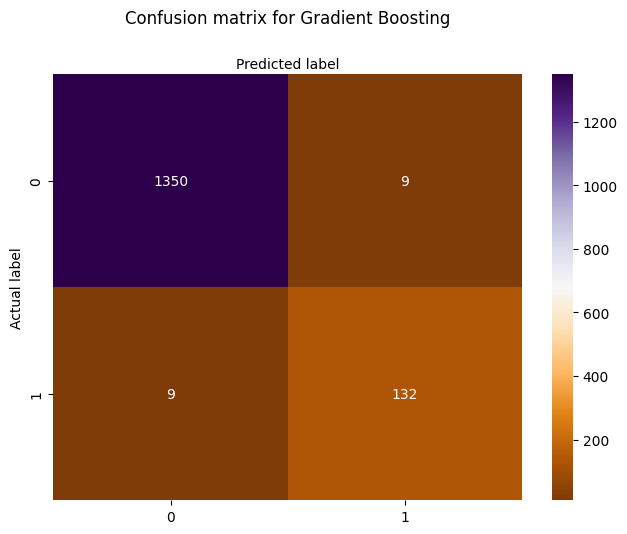

In [22]:
import seaborn as sns
from matplotlib import pyplot as plt
print("The confusion matrix is as follows")
class_names=["No","Yes"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_test)), annot=True, cmap="PuOr" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix for Gradient Boosting', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
pickle.dump(mdl, open('../Model_Objects/pl_prediction_model.pkl','wb'))